# AidSDK部署-三十类水果-摄像头和视频-中文

同济子豪兄 2023-6-25

本代码在AidLux手机端运行

## 导入工具包

In [1]:
import cv2
import PIL
from cvs import *
import numpy as np
from PIL import Image, ImageFont, ImageDraw
import aidlite_gpu

import matplotlib.pyplot as plt
%matplotlib inline

## 载入中文字体

In [2]:
from PIL import ImageFont, ImageDraw
# 导入中文字体，指定字号
font = ImageFont.truetype('SimHei.ttf', 32)

## 加载TFLite模型

In [11]:
model_path = 'resnet18_fruit30.tflite'

In [12]:
NUM_CLASS = 30 # 指定类别个数

In [13]:
aidlite = aidlite_gpu.aidlite()

# 模型路径 输入维度 输出维度 线程数 是否开启NNAPI
# https://docs.aidlux.com/#/intro/ai/ai-aidlite?id=_4fast_annmodel
aidlite.FAST_ANNModel(model_path, [256*256*3*4], [NUM_CLASS*4], 4, 0)

[2023-08-04 22:36:26,074225][/tmp/ipykernel_15177/2808051052.py:1 <module>][DEBUG]:=======init


Result(id=1, result='load model ok!', error=None)

## 载入类别名称与ID映射表

In [14]:
# 中文类别名称
idx_to_labels = np.load('idx_to_labels.npy', allow_pickle=True).item()

## 初始化摄像头

In [15]:
# 摄像头ID 0-后置 1-前置
Camera_ID = 0

In [16]:
cap = cvs.VideoCapture(Camera_ID)

('app runs on port:', 64536)
open the cam:0 ...


Exception in thread Thread-4948:
Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 917, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 865, in run
    self._target(*self._args, **self._kwargs)
  File "cvs.py", line 184, in cvs.startcv
  File "/usr/local/lib/python3.7/dist-packages/remi/server.py", line 925, in start
    s = Server(main_gui_class, start=True, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/remi/server.py", line 816, in __init__
    self.start()
  File "/usr/local/lib/python3.7/dist-packages/remi/server.py", line 834, in start
    self, self._certfile, self._keyfile, self._ssl_version, *self._userdata)
  File "/usr/local/lib/python3.7/dist-packages/remi/server.py", line 762, in __init__
    HTTPServer.__init__(self, server_address, RequestHandlerClass)
  File "/usr/lib/python3.7/socketserver.py", line 452, in __init__
    self.server_bind()
  File "/usr/lib/python3.7/http/aid_server.py", line 138

## 逐帧处理函数

In [17]:
def process_frame(img_bgr):
    
    # 记录该帧开始处理的时间
    start_time = time.time()
    
    ## 预处理
    img_tensor = cv2.resize(img_bgr, (256, 256)) # 尺寸缩放
    mean = (0.485, 0.456, 0.406) # 三通道的均值
    std = (0.229, 0.224, 0.225) # 三通道的标准差
    img_tensor = ((img_tensor / 255) - mean) / std
    img_tensor = img_tensor.astype('float32')
    
    ## 推理预测
    aidlite.setInput_Float32(img_tensor) # 装填数据
    aidlite.invoke() # 推理预测
    result = aidlite.getOutput_Float32() # 获得推理预测结果
    
    ## 解析预测结果
    pred_id = np.argmax(result) # 置信度最高类别 ID
    pred_class = idx_to_labels[pred_id] # 置信度最高类别名称
    
    ## 将预测中文类别写在图片上
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # BGR转RGB
    img_pil = Image.fromarray(img_rgb) # array 转 PIL
    draw = ImageDraw.Draw(img_pil)
    draw.text((50, 150), pred_class, font=font, fill=(0, 0, 255, 1)) # 文字坐标，中文字符串，字体，rgba颜色
    img_rgb = np.array(img_pil) # PIL 转 array
    img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR) # RGB 转 BGR
    
    # 记录该帧处理完毕的时间
    end_time = time.time()
    # 计算每秒处理图像帧数FPS
    FPS = 1/(end_time - start_time)
    # 在画面上写字：图片，字符串，左上角坐标，字体，字体大小，颜色，字体粗细
    FPS_string = 'FPS {:.2f}'.format(FPS) # 写在画面上的字符串
    img_output = cv2.putText(img_bgr, FPS_string, (50, 120), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    
    return img_output

## 预测摄像头单帧画面

In [18]:
img_bgr = cap.read()

In [20]:
img_bgr = process_frame(img_bgr)

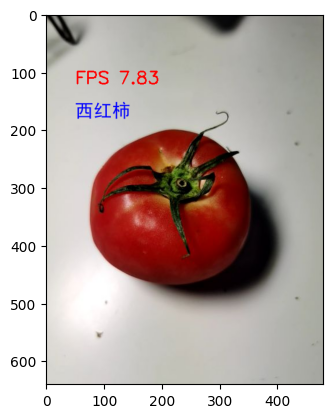

In [54]:
plt.imshow(img_bgr[:,:,::-1])
plt.show()

## 逐帧实时处理手机摄像头拍摄的画面-代码模板

In [ ]:
while True:
    img_bgr = cap.read()
    
    if img_bgr is None:
        continue
        
    img_bgr = process_frame(img_bgr)
    
    cvs.imshow(img_bgr)

> 点击`重启kernel`关闭摄像头

## 视频逐帧处理（模板）

In [25]:
import cv2
import numpy as np
import time
from tqdm import tqdm

# 视频逐帧处理代码模板
# 不需修改任何代码，只需定义process_frame函数即可
# 同济子豪兄 2021-7-10

def generate_video(input_path='videos/robot.mp4'):
    filehead = input_path.split('/')[-1]
    output_path = "out-" + filehead
    
    print('视频开始处理',input_path)
    
    # 获取视频总帧数
    cap = cv2.VideoCapture(input_path)
    frame_count = 0
    while(cap.isOpened()):
        success, frame = cap.read()
        frame_count += 1
        if not success:
            break
    cap.release()
    print('视频总帧数为',frame_count)
    
    # cv2.namedWindow('Crack Detection and Measurement Video Processing')
    cap = cv2.VideoCapture(input_path)
    frame_size = (cap.get(cv2.CAP_PROP_FRAME_WIDTH), cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # fourcc = int(cap.get(cv2.CAP_PROP_FOURCC))
    # fourcc = cv2.VideoWriter_fourcc(*'XVID')
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    fps = cap.get(cv2.CAP_PROP_FPS)

    out = cv2.VideoWriter(output_path, fourcc, fps, (int(frame_size[0]), int(frame_size[1])))
    
    # 进度条绑定视频总帧数
    with tqdm(total=frame_count-1) as pbar:
        try:
            while(cap.isOpened()):
                success, frame = cap.read()
                if not success:
                    break

                # 处理帧
                # frame_path = './temp_frame.png'
                # cv2.imwrite(frame_path, frame)
                try:
                    frame = process_frame(frame)
                except:
                    print('报错！', error)
                    pass
                
                if success == True:
                    # cv2.imshow('Video Processing', frame)
                    out.write(frame)

                    # 进度条更新一帧
                    pbar.update(1)

                # if cv2.waitKey(1) & 0xFF == ord('q'):
                    # break
        except:
            print('中途中断')
            pass

    cv2.destroyAllWindows()
    out.release()
    cap.release()
    print('视频已保存', output_path)

In [27]:
generate_video(input_path='fruits_video.mp4')

视频开始处理 fruits_video.mp4
视频总帧数为 212


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 211/211 [01:01<00:00,  3.41it/s]

视频已保存 out-fruits_video.mp4



remi.server.ws   ERROR    Error managing incoming websocket message
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/remi/server.py", line 166, in read_next_message
    length = self.bytetonum(length[1]) & 127
IndexError: index out of range
